In [17]:
#importing libraries
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import Adam, SGD

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow.compat.v2 as tf

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Concatenate
from tensorflow.keras.utils import plot_model

import numpy as np 

from ipynb.fs.full.utils_NN import*

def red(
        sep = ',',
        classification = 1, 
        dropout = 1 ,
        p = 0.3,
        a = 5,
        b = 2
        ):
    
    directory = ['D:/benja/Ondas/Code/data/timeFrecuency','D:/benja/Ondas/Code/data/timeFrecuency_mel']
    #directory = ['2000 data']
    nam = ['mor','mel']
    dist = ['0.1','5.05','10']
    
    filters = [8,8,8,8,8,8]
    
    hist = []
    
    for k in range(len(directory)):
        
        
        
        if k==0:
            timeInd = 256
            levels = 64
            
        else:
            timeInd = 513
            levels = 40
            
        channels = 1
        
        for j in range(len(dist)):
            
           
            
            #x,y = load_data(directory[k], dist[j], sep, multclass= classification)
            
            
            
            for z in range(1,7):
                
                filters_len = z
                if not (k == 1 and z == 6):
                    print(
                    'directorio : '+ directory[k]
                        + ' \n distanca ' + dist[j]
                        + ' \n cantidad de capas ' + str(filters_len)
                    )
                    
                    inputLayer = Input((timeInd, levels,channels))
                    CONV = inputLayer
                    
                    for i in range( filters_len ):
                        
                        CONV = Conv2D(filters=filters[i], kernel_size=(3,3), padding='same', activation='relu')(CONV)
                        CONV = MaxPool2D(pool_size=(2,2), strides=2)(CONV)
                        
                        if dropout:
                            CONV = Dropout(p)(CONV)
                        else:
                            CONV = Soft_Dropout(a,b)(CONV)
                    DENSE = Flatten()(CONV)
                    
                    if not classification:
                        out = Dense(units=1, activation='sigmoid')(DENSE)
                    else:
                        out = Dense(units=2, activation='softmax')(DENSE)
                        
                    model_astone = Model(inputs=[inputLayer], outputs=[out], name = "model_astone")
                    
                    model_astone.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.FalsePositives()])
                    
                    #x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=1)
                    
                    batch_size = 500
                    
                    #load X_train_filenames y_train, X_val_filenames, y_val
                    
                    X_train_filenames = np.load(directory[k] + '_names_'+ dist[j] + '/train_list_dist_' + dist[j] +'.npy')
                    y_train = np.load(directory[k] + '_names_'+ dist[j] + '/train_labels_dist_' + dist[j] +'.npy')
                    
                    X_val_filenames = np.load(directory[k] + '_names_'+ dist[j] + '/val_list_dist_' + dist[j] +'.npy')
                    y_val = np.load(directory[k] + '_names_'+ dist[j] + '/val_labels_dist_' + dist[j] +'.npy')
                    
                    my_training_batch_generator = My_Custom_Generator(X_train_filenames, y_train, batch_size)
                    my_validation_batch_generator = My_Custom_Generator(X_val_filenames, y_val, batch_size)
                    
                    
                    early_stopping = EarlyStoppingTresh(monitor='val_loss', threshold=0.0001)
                    
                    print('Entrenando red...')
                    
                    history = model_astone.fit(
                                    my_training_batch_generator,
                                    steps_per_epoch = int( len(X_train_filenames) // batch_size),
                                    validation_data = my_validation_batch_generator,
                                    validation_steps = int( len(X_val_filenames) // batch_size),
                                    epochs = 1,
                                    #batch_size = 50,
                                    #callbacks=[early_stopping],
                                    verbose=1)
                    
                    path = "redes/"+nam[k]+"_dist-" + dist[k] + ' filters-' + str(filters_len)+".h5"
                    model_astone.save(path)
                    
                    hist.append(history)
                    
                    #metrics = model_astone.evaluate(x_test, y_test, verbose=1)
                    
                    #graficar las metricas
                    if False:
                        
                        graph_name = 'spectrogram\n Metrics \n'+    'dist-' + dist[k] + ' filters-' + str(len(filters))+ ' acc-'+ str(metrics[1])
                        graph_metrics(history, graph_name)
                        
        
    return hist

In [18]:
history= red()

directorio : D:/benja/Ondas/Code/data/timeFrecuency 
 distanca 0.1 
 cantidad de capas 1
Entrenando red...
5/5 [==============================] - 48s 10s/step - loss: 0.4526 - accuracy: 0.5883 - false_positives_75: 947.0000 - val_loss: 0.1423 - val_accuracy: 1.0000 - val_false_positives_75: 0.0000e+00
directorio : D:/benja/Ondas/Code/data/timeFrecuency 
 distanca 0.1 
 cantidad de capas 2
Entrenando red...
5/5 [==============================] - 51s 11s/step - loss: 0.4314 - accuracy: 0.6839 - false_positives_76: 727.0000 - val_loss: 0.3107 - val_accuracy: 1.0000 - val_false_positives_76: 0.0000e+00
directorio : D:/benja/Ondas/Code/data/timeFrecuency 
 distanca 0.1 
 cantidad de capas 3
Entrenando red...
5/5 [==============================] - 51s 11s/step - loss: 0.5647 - accuracy: 0.6487 - false_positives_77: 808.0000 - val_loss: 0.5347 - val_accuracy: 1.0000 - val_false_positives_77: 0.0000e+00
directorio : D:/benja/Ondas/Code/data/timeFrecuency 
 distanca 0.1 
 cantidad de capas 4
En

directorio : D:/benja/Ondas/Code/data/timeFrecuency_mel 
 distanca 5.05 
 cantidad de capas 5
Entrenando red...
5/5 [==============================] - 57s 12s/step - loss: 0.7520 - accuracy: 0.5200 - false_positives_102: 1104.0000 - val_loss: 0.6942 - val_accuracy: 0.3770 - val_false_positives_102: 623.0000
directorio : D:/benja/Ondas/Code/data/timeFrecuency_mel 
 distanca 10 
 cantidad de capas 1
Entrenando red...
5/5 [==============================] - 69s 15s/step - loss: 1.5407 - accuracy: 0.4974 - false_positives_103: 1156.0000 - val_loss: 1.0722 - val_accuracy: 0.5320 - val_false_positives_103: 468.0000
directorio : D:/benja/Ondas/Code/data/timeFrecuency_mel 
 distanca 10 
 cantidad de capas 2
Entrenando red...
5/5 [==============================] - 64s 13s/step - loss: 0.8264 - accuracy: 0.4930 - false_positives_104: 1166.0000 - val_loss: 0.7116 - val_accuracy: 0.5320 - val_false_positives_104: 468.0000
directorio : D:/benja/Ondas/Code/data/timeFrecuency_mel 
 distanca 10 
 canti

In [24]:
new_model = keras.models.load_model('redes/mor_dist-0.1 filters-1.h5')

In [25]:
new_model.summary()

Model: "model_astone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_89 (InputLayer)       [(None, 256, 64, 1)]      0         
                                                                 
 conv2d_283 (Conv2D)         (None, 256, 64, 8)        80        
                                                                 
 max_pooling2d_283 (MaxPooli  (None, 128, 32, 8)       0         
 ng2D)                                                           
                                                                 
 dropout_283 (Dropout)       (None, 128, 32, 8)        0         
                                                                 
 flatten_87 (Flatten)        (None, 32768)             0         
                                                                 
 dense_87 (Dense)            (None, 2)                 65538     
                                                      

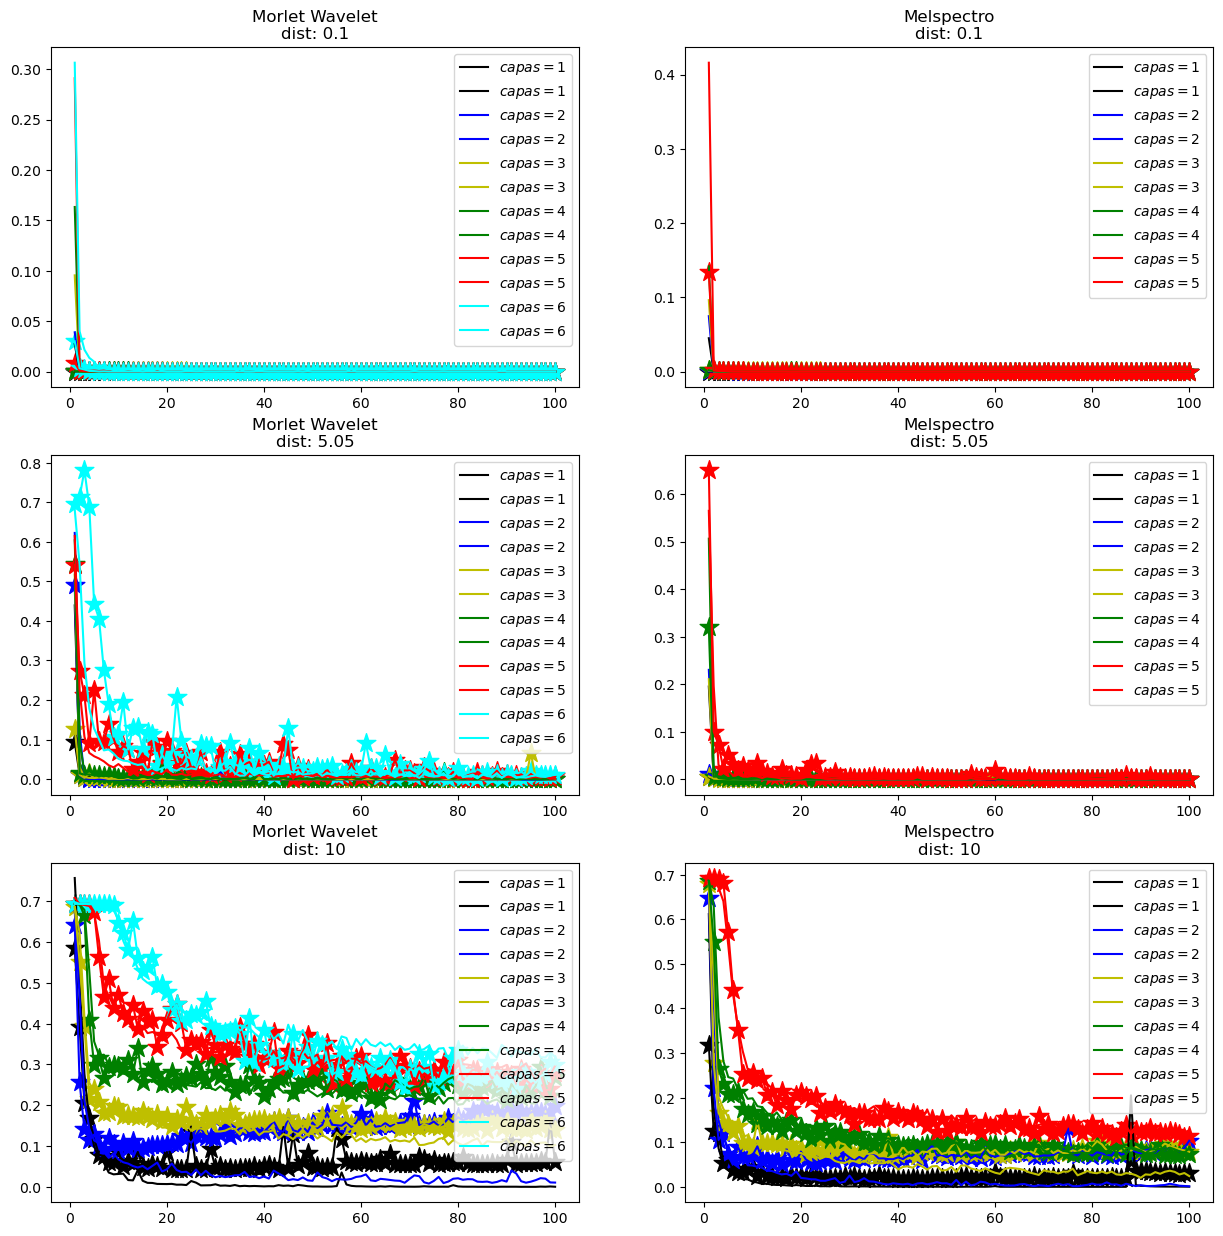

In [230]:
names = ['Morlet Wavelet','Melspectro']

dist = ['0.1','5.05','10']
ind = 0

metric= 'loss'
metric2 = 'val_loss'

fig, axs = plt.subplots(3,2,figsize=(15, 15))

color = ['k','b','y','g','r','cyan']

plts = []

for i in range(len(names)):
    for j in range(len(dist)):
        for z in range(1,7):
            if not (i == 1 and z == 6):
                    
                    #print(ind)
                acc = history[ind].history[metric]
                acc2 = history[ind].history[metric2]
                epochs = range(1,len(acc) + 1 )
                axs[j,i].plot(epochs, acc, label='$capas = {i}$'.format(i=z),color=color[z-1])
                axs[j,i].plot(epochs, acc2, label='$capas = {i}$'.format(i=z),color= color[z-1])
                
                axs[j,i].scatter(epochs, acc2, s=200, marker='*', color= color[z-1])
                
                ind = ind +1
                    
        axs[j,i].set_title(names[i]+'\ndist: '+dist[j])
        axs[j,i].legend(loc='best')
            
plt.savefig('plots/allruns_acc_per_layers.png')

In [196]:
names = ['Morlet Wavelet','Melspectro']

dist = ['0.1','5.05','10']
ind = 0

metric= 'val_accuracy'

#fig, axs = plt.subplots(3,2,figsize=(15, 15))

plts = []
accs = [[],[]]
for i in range(len(names)):
    for j in range(len(dist)):
        for z in range(1,7):
            if not (i == 1 and z == 6):
                
                #print(ind)
                accs[i].append(history[ind].history[metric][-1])
                
                #plts.append(axs[j,i].plot(epochs, acc, label='$capas = {i}$'.format(i=z)))
                ind = ind +1
                
        #axs[j,i].set_title(names[i]+'\ndist: '+dist[j])
        #axs[j,i].legend(loc='best')
        
wavelet, mels = np.array(accs[0]), np.array(accs[1])


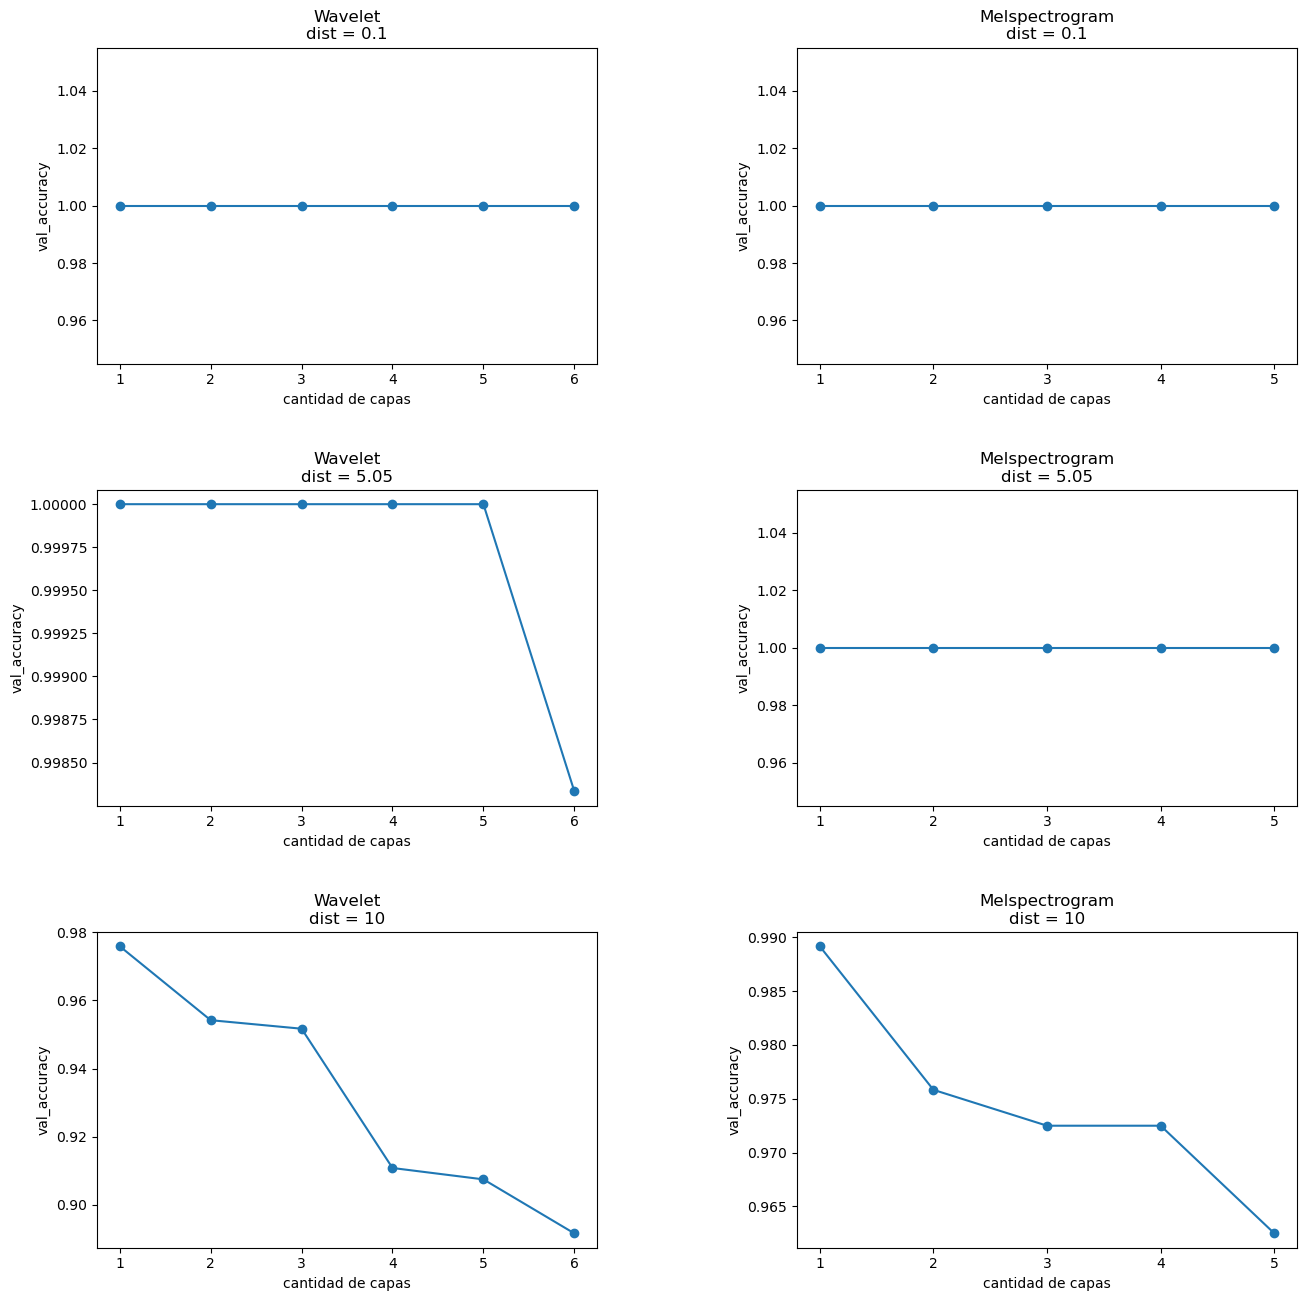

In [197]:

dist = ['0.1','5.05','10']

m = (wavelet, mels)


names = ['Wavelet','Melspectrogram']

fig, axs = plt.subplots(3,2,figsize=(15, 15))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for z in range(2):
    ind = 0
    for i in range(3):
        a = []
        for j in range(1, (len(m[z])//3 )+1):

            a.append( [ int(j), m[z][ind] ] )
            ind = ind+1
        #a = np.array(a)
        #print(np.array(a)[:,1])
        
        axs[i,z].plot( np.array(a)[:,0], np.array(a)[:,1] )
        axs[i,z].scatter( np.array(a)[:,0], np.array(a)[:,1] )
        axs[i,z].set_title(names[z]+'\ndist = '+dist[i])
        axs[i,z].set_xticks(range(1,(len(m[z])//3 )+1))
        axs[i,z].set(xlabel="cantidad de capas",ylabel="val_accuracy")
        
plt.savefig('plots/allruns_acc_per_dist.png')
    